In [1]:
import os
# !pwd

from pathlib import Path

dir_path = Path(r"/Users/rabinatwayana/Rabina/CDE II/Wildfire Project/SAR-Burnt-Area-Mapping/")

if dir_path.exists():
    os.chdir(dir_path)
else:
    print("Directory does not exist! Please check the path.")

In [2]:
import rasterio
from scipy.ndimage import uniform_filter
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from utils import predict


In [3]:
scheme_1 =False
scheme_2 =False
scheme_3 =False
scheme_4 =False
scheme_5 =False
scheme_6 =False
scheme_7 =False
scheme_8 =True


file_paths=[]


In [4]:

if scheme_1:
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_avg_asc.pkl"
    # eaton={
    #     "model_path":model_path ,
    #     "feature_image_path": "output/feature_image/eaton_sar_asc.tif",
    #     "output_file_path": "output/prediction/1_palisadesRF_eaton_sar_asc.tif",
    #     "output_image_path": "output/prediction_img/1_palisadesRF_eaton_sar_asc.png",
    #     "title":"Scheme 1"

    # }
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_avg_asc.tif",
        "output_file_path": "MachineLearning/output/prediction/palisadesRF_sar_avg_asc.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisadesRF_sar_avg_asc.png",
        "title":"Scheme 1"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)

     

if scheme_2:
    #1 Asc glcm
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_avg_desc.pkl"
    # eaton={
    #     "model_path":model_path ,
    #     "feature_image_path": "MachineLearning/output/feature_image/eaton_sar_asc_glcm.tif",
    #     "output_file_path": "MachineLearning/output/prediction/2_palisadesRF_eaton_sar_asc_glcm.tif",
    #     "output_image_path": "MachineLearning/output/prediction_img/2_palisadesRF_eaton_sar_asc_glcm.png",
    #     "title":"Scheme 2"

    # }
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_avg_desc.tif",
        "output_file_path": "MachineLearning/output/prediction/palisades_sar_avg_desc.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisades_sar_avg_desc.png",
        "title":"Scheme 2"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)

    
    
if scheme_3:
    #1 Asc avg
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_avg_asc_desc.pkl"
    # eaton={
    #     "model_path":model_path ,
    #     "feature_image_path": "output/feature_image/eaton_sar_avgasc.tif",
    #     "output_file_path": "output/prediction/3_palisadesRF_eaton_sar_avgasc.tif",
    #     "output_image_path": "output/prediction_img/3_palisadesRF_eaton_sar_avgasc.png",
    #     "title":"Scheme 3"

    # }
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_avg_asc_desc.tif",
        "output_file_path": "MachineLearning/output/prediction/palisades_sar_avg_asc_desc.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisades_sar_avg_asc_desc.png",
        "title":"Scheme 3"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)


    
if scheme_4:
    #1 Asc avg + glcm
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_avg_asc_desc_glcm.pkl"
    # eaton={
    #     "model_path":model_path ,
    #     "feature_image_path": "output/feature_image/eaton_sar_avgasc_glcm.tif",
    #     "output_file_path": "output/prediction/4_palisadesRF_eaton_sar_avgasc_glcm.tif",
    #     "output_image_path": "output/prediction_img/4_palisadesRF_eaton_sar_avgasc_glcm.png",
    #     "title":"Scheme 4"

    # }
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_avg_asc_desc_glcm.tif",
        "output_file_path": "MachineLearning/output/prediction/palisadesRF_sar_avg_asc_desc_glcm.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisadesRF_sar_avg_asc_desc_glcm.png",
        "title":"Scheme 4"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)


if scheme_5:
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_single_asc.pkl"
   
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_single_asc.tif",
        "output_file_path": "MachineLearning/output/prediction/palisadesRF_sar_single_asc.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisadesRF_sar_single_asc.png",
        "title":"Scheme 5"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)

if scheme_6:
    #1 Asc glcm
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_single_desc.pkl"
    
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_single_desc.tif",
        "output_file_path": "MachineLearning/output/prediction/palisades_sar_single_desc.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisades_sar_single_desc.png",
        "title":"Scheme 6"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)

    
    
if scheme_7:
    #1 Asc avg
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_single_asc_desc.pkl"
    
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_single_asc_desc.tif",
        "output_file_path": "MachineLearning/output/prediction/palisades_sar_single_asc_desc.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisades_sar_single_asc_desc.png",
        "title":"Scheme 7"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)


    
if scheme_8:
    #1 Asc avg + glcm
    model_path="MachineLearning/output/model/RandomForest_palisades_sar_single_asc_desc_glcm.pkl"
    
    palisades={
        "model_path": model_path,
        "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_single_asc_desc_glcm.tif",
        "output_file_path": "MachineLearning/output/prediction/palisadesRF_sar_single_asc_desc_glcm.tif",
        "output_image_path": "MachineLearning/output/prediction_img/palisadesRF_sar_single_asc_desc_glcm.png",
        "title":"Scheme 8"
    }

    # file_paths.append(eaton)
    file_paths.append(palisades)


# if scheme_5:
#     #avg asc + desc

    # model_path="MachineLearning/output/model/RandomForest_palisades_sar_glcm.pkl"
    # # eaton={
    # #     "model_path":model_path ,
    # #     "feature_image_path": "output/feature_image/eaton_sar_avgasc_desc.tif",
    # #     "output_file_path": "output/prediction/6_palisadesRF_eaton_sar_avgasc_desc.tif",
    # #     "output_image_path": "output/prediction_img/6_palisadesRF_eaton_sar_avgasc_desc.png",
    # #     "title":"Scheme 5"

    # # }
    # palisades={
    #     "model_path": model_path,
    #     "feature_image_path": "MachineLearning/output/feature_image/palisades_sar_glcm.tif",
    #     "output_file_path": "MachineLearning/output/prediction/5_palisadesRF_sar_glcm.tif",
    #     "output_image_path": "MachineLearning/output/prediction_img/5_palisadesRF_sar_glcm.png",
    #     "title":"Scheme 5"
    # }

    # # file_paths.append(eaton)
    # file_paths.append(palisades)

  
# if scheme_6:
#     #avg asc + desc + glcm
#     model_path="output/model/RandomForest_palisades_sar_avgasc_desc_glcm.pkl"
#     eaton={
#         "model_path":model_path ,
#         "feature_image_path": "output/feature_image/eaton_sar_avgasc_desc_glcm.tif",
#         "output_file_path": "output/prediction/6_palisadesRF_eaton_sar_avgasc_desc_glcm.tif",
#         "output_image_path": "output/prediction_img/6_palisadesRF_eaton_sar_avgasc_desc_glcm.png",
#         "title":"Scheme 6"

#     }
#     palisades={
#         "model_path": model_path,
#         "feature_image_path": "output/feature_image/palisades_sar_avgasc_desc_glcm.tif",
#         "output_file_path": "output/prediction/6_palisadesRF_sar_avgasc_desc_glcm.tif",
#         "output_image_path": "output/prediction_img/6_palisadesRF_sar_avgasc_desc_glcm.png",
#         "title":"Scheme 6"
#     }

#     file_paths.append(eaton)
#     file_paths.append(palisades)

    

In [5]:
# dataset = rasterio.open("output/feature_image/palisades_sar_indices.tif")
# print(dataset.count)

# # Iterate through all bands
# for band in range(1, dataset.count + 1):
#     band_data = dataset.read(band)  # Read the band
#     min_val = np.min(band_data)
#     max_val = np.max(band_data)
    
#     print(f"Band {band}: Min = {min_val}, Max = {max_val}")

# # Close the dataset
# dataset.close()

In [6]:
# ml_models=os.listdir(output_model_dir)
# for model_name in ml_models:
#     output_model_path = os.path.join(output_model_dir, model_name)
#     # Load the saved model
#     loaded_model = joblib.load(output_model_path)

#     # Use the loaded model to make predictions
#     # predictions = loaded_model.predict(X_test)
#     predict(loaded_model, sar_image_path,model_name.replace(".pkl",""))

8
[0. 1.]
Predictions saved to MachineLearning/output/prediction/palisadesRF_sar_single_asc_desc_glcm.tif


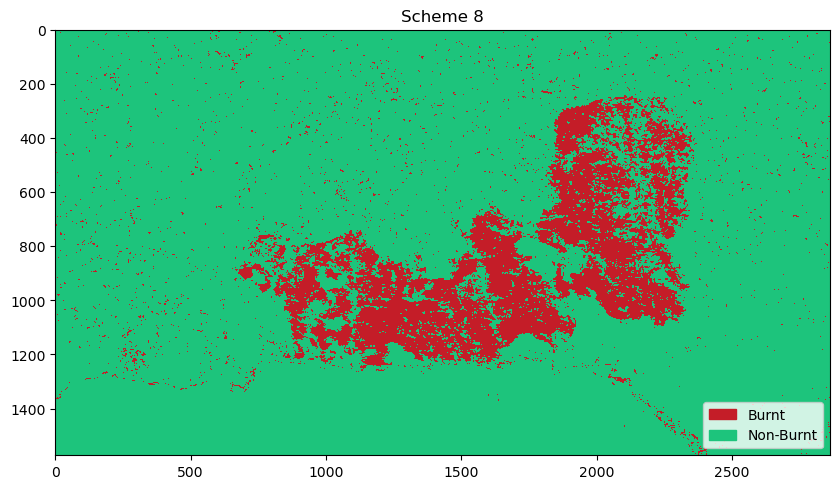

In [7]:
# Loop through each set of paths
for paths in file_paths:
    model_path = paths["model_path"]
    feature_image_path = paths["feature_image_path"]
    output_file_path = paths["output_file_path"]
    output_image_path=paths['output_image_path']
    title=paths['title']

    loaded_model = joblib.load(model_path)

    # Use the loaded model to make predictions
    # predictions = loaded_model.predict(X_test)
    predict(loaded_model, feature_image_path,output_file_path,output_image_path,title)

    # print(f"Processing Model: {model_path}")
    # print(f"Feature Image: {feature_image_path}")
    # print(f"Output File: {output_file_path}\n")